In [29]:
#link dataset: https://data.world/data-society/air-traffic-passenger-data
#nume fisier dataset: Air_Traffic_Passenger_Statistics.csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

%matplotlib inline
plt.style.use('fivethirtyeight')
import plotly.offline as py
import plotly.figure_factory as ff
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from datetime import datetime

In [30]:
# importare si afisare set de date din fisierul csv
df = pd.read_csv('Air_Traffic_Passenger_Statistics.csv')
print(f"Forma setului de date: {df.shape}")
print(df.head(5))

Forma setului de date: (15007, 16)
   Activity Period Operating Airline Operating Airline IATA Code  \
0           200507      ATA Airlines                          TZ   
1           200507      ATA Airlines                          TZ   
2           200507      ATA Airlines                          TZ   
3           200507       Air Canada                           AC   
4           200507       Air Canada                           AC   

  Published Airline Published Airline IATA Code    GEO Summary GEO Region  \
0      ATA Airlines                          TZ       Domestic         US   
1      ATA Airlines                          TZ       Domestic         US   
2      ATA Airlines                          TZ       Domestic         US   
3       Air Canada                           AC  International     Canada   
4       Air Canada                           AC  International     Canada   

  Activity Type Code Price Category Code    Terminal Boarding Area  \
0           Deplaned   

In [31]:
# aflare mai multe detalii despre setul de date(data de inceput, data finala, durata in zile samd)
time_begin = df.loc[:,"Activity Period"].min() # data de inceput
time_end = df.loc[:,"Activity Period"].max() # data de sfarsit din dataset(maxima)

date_begin = datetime.strptime(str(time_begin), '%Y%m')
date_end = datetime.strptime(str(time_end), '%Y%m')
time_range = date_end - date_begin # intervalul de timp dintre maxim si minim(max-min)

print("Prima data(minima): ", str(time_begin)[:4], "/", str(time_begin)[4:])
print("Ultima data(maxima): ", str(time_end)[:4], "/", str(time_end)[4:])
print("Intervalul de timp in zile: ", time_range.days)

Prima data(minima):  2005 / 07
Ultima data(maxima):  2016 / 03
Intervalul de timp in zile:  3896


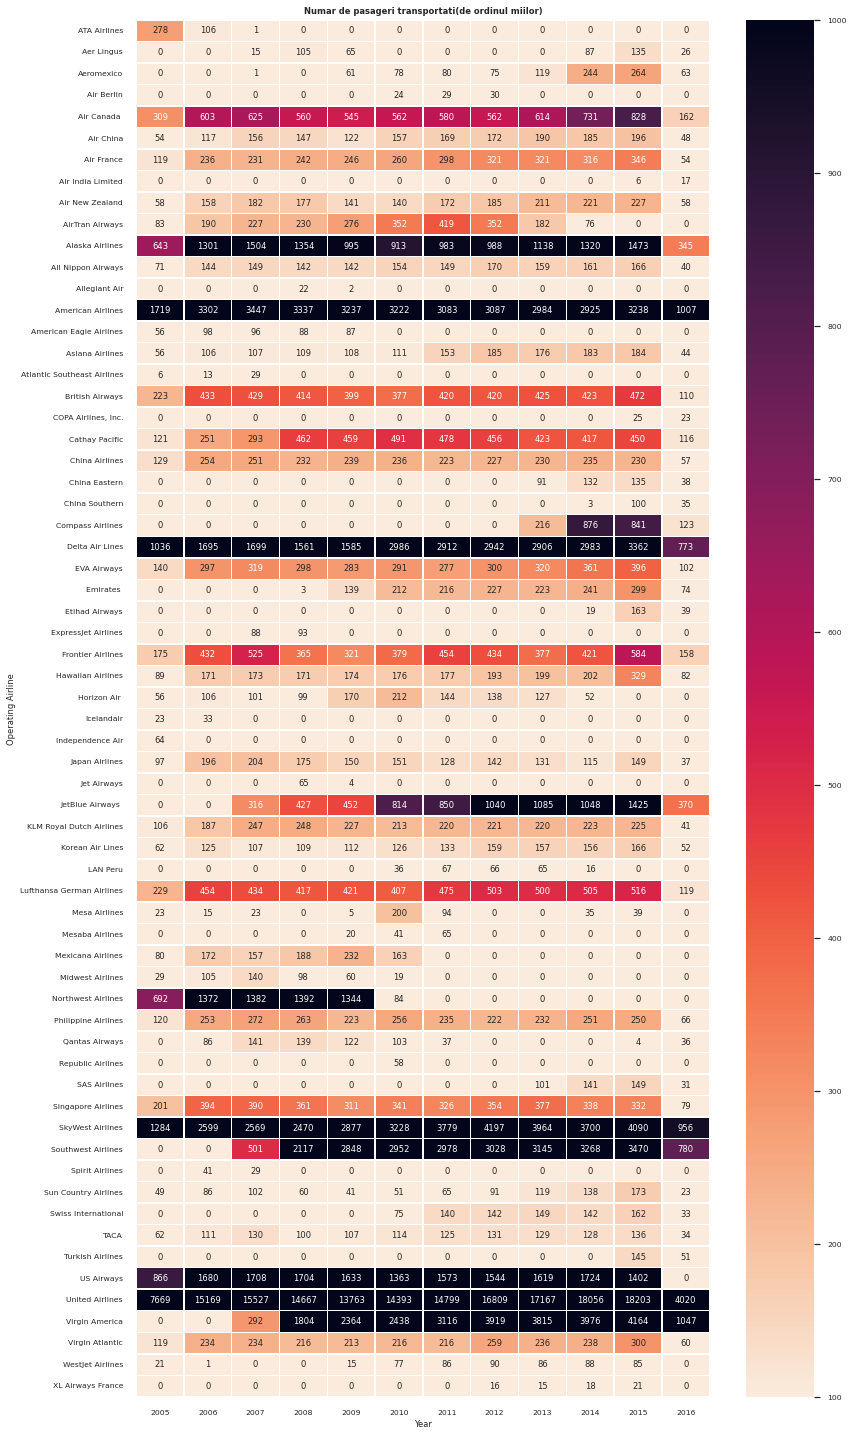

In [32]:
# heatmap pentru toate companiile in functie de numarul de zboruri, regiunea geografica si numarul de pasageri, per an
PAX_airline_yr = df.groupby(["Year","Operating Airline"])["Passenger Count"].sum().divide(1000)
PAX_airline_yr = PAX_airline_yr.reset_index()
pivot_1 = PAX_airline_yr.pivot_table(values="Passenger Count",index="Operating Airline",columns="Year", fill_value=0)
pivot_1.loc["United Airlines",:] = pivot_1.loc["United Airlines",:] + pivot_1.loc["United Airlines - Pre 07/01/2013",:]
pivot_1.drop("United Airlines - Pre 07/01/2013",axis=0, inplace=True)

# eliminarea companiilor mici(cu zboruri rare/putine)
dropped = pivot_1[pivot_1.sum(axis=1)<13]
pivot_1 = pivot_1.drop(dropped.index,axis=0)

sns.set(font_scale=0.7)
fig1 = plt.figure(figsize=(12,20))
p1 = sns.heatmap(pivot_1, annot=True, linewidths=.5, vmin=100, vmax=1000, fmt='.0f', cmap=sns.cm.rocket_r)
p1.set_title("Numar de pasageri transportati(de ordinul miilor)", fontweight="bold")
p1.set_yticklabels(p1.get_yticklabels(), rotation=0)
plt.tight_layout()

In [34]:
# aflare top 5 companii aeriene in functie de media pasagerilor transportati/an si reprezentarea acestora ca procent
avg_airline = pivot_1.mean(axis=1)
TOP5_airlines = avg_airline.nlargest(5).to_frame().mul(1000).astype("int64")
TOP5_airlines.columns = ["Media pasagerilor/An"]
sum_of_all = TOP5_airlines.loc[:,"Media pasagerilor/An"].sum()
TOP5_airlines.loc[:,"Procent [in pct]"] = TOP5_airlines.loc[:,"Media pasagerilor/An"].div(sum_of_all).mul(100).round(1)
TOP5_airlines

,Media pasagerilor/An,Procent [in pct]
Operating Airline,,
United Airlines,14186742,57.9
SkyWest Airlines,2975978,12.2
American Airlines,2882392,11.8
Virgin America,2244561,9.2
Delta Air Lines,2203368,9.0


<AxesSubplot:title={'center':'Ponderea regiunilor geografice raportate la traficul total'}, xlabel='Year'>

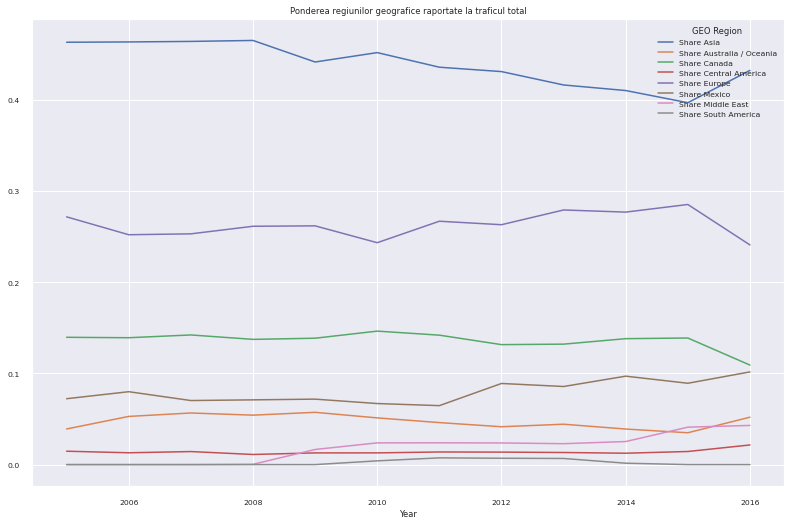

In [35]:
# aflare pondere a regiunilor geografice raportate la traficul total
grph = df.groupby(["Year","GEO Region"])["Passenger Count"].sum()
grph = grph.reset_index()

pivot_5 = grph.pivot_table(values="Passenger Count",index="Year",columns="GEO Region", fill_value=0)
pivot_5 = pivot_5.drop("US",axis=1)
pivot_5["Total"] = pivot_5.sum(axis=1)

for col in pivot_5.columns[:-1]:
        pivot_5["Share " + str(col)]=pivot_5[col]/pivot_5["Total"]

ratios_5 = pivot_5.iloc[:,-8:]
ratios_5.plot(figsize=(12,8), title="Ponderea regiunilor geografice raportate la traficul total")


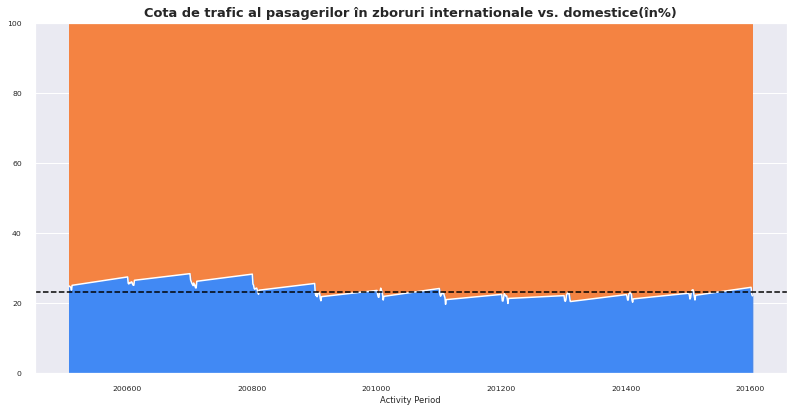

In [36]:
CotaTrafic = df.groupby(["Activity Period","GEO Summary"])["Passenger Count"].sum()
CotaTrafic = CotaTrafic.reset_index()

pivot_4 = CotaTrafic.pivot_table(values="Passenger Count",index="Activity Period",columns="GEO Summary", fill_value=0)
pivot_4["Share"] = (pivot_4["International"]/(pivot_4["Domestic"]+pivot_4["International"])).mul(100)
mean_CotaTrafic = pivot_4["Share"].mean()

fig4, ax4 = plt.subplots(figsize=(12,6))
plt.title("Cota de trafic al pasagerilor în zboruri internationale vs. domestice(în%)", fontdict={'fontsize':13,'fontweight' : "bold"})
plt.ylim(0,100)

pivot_4["Share"].plot(ax=ax4, c="white")
ax4.fill_between(pivot_4.index, 100, color='#f48342')
ax4.fill_between(pivot_4.index, pivot_4["Share"], color='#4189f4')
ax4.axhline(mean_CotaTrafic, c="black", linestyle="--")
plt.show()

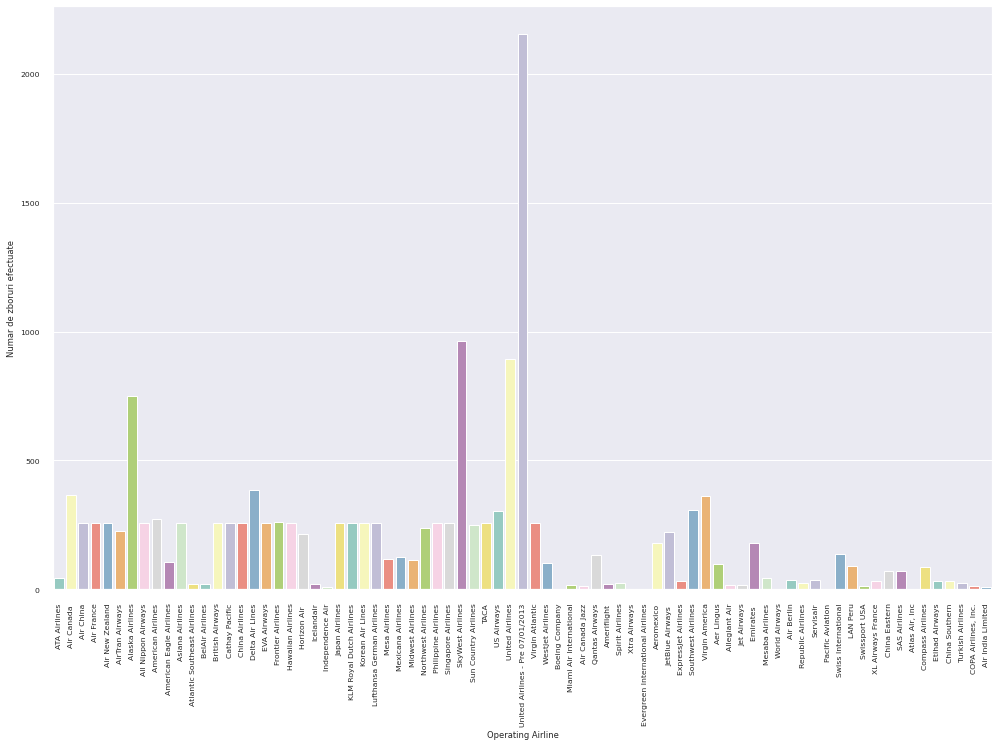

In [37]:
# countplot in functie de fiecare companie si zborurile efectuate de acestea
plt.figure(figsize = (15,10))
sns.countplot(x = "Operating Airline", palette = "Set3",data = df)
plt.xticks(rotation = 90)
plt.ylabel("Numar de zboruri efectuate")
plt.show()

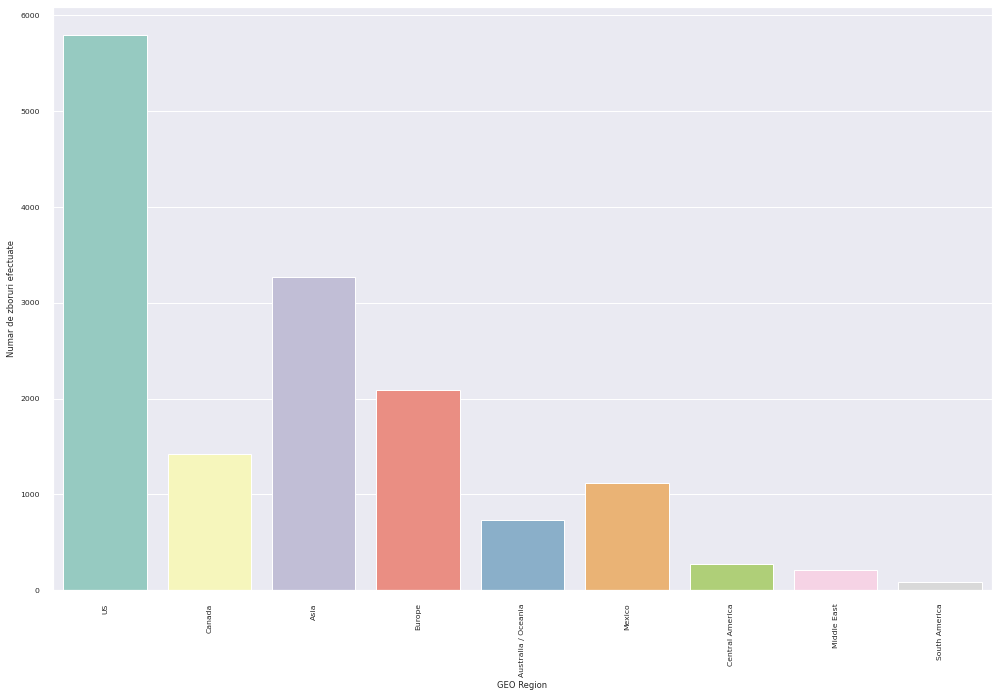

In [38]:
# countplot in functie de regiunea geografica si zborurile efectuate in aceste regiuni
plt.figure(figsize = (15,10))
sns.countplot(x = "GEO Region", palette = "Set3",data = df)
plt.xticks(rotation = 90)
plt.ylabel("Numar de zboruri efectuate")
plt.show()

In [39]:
airline_count = df["Operating Airline"].value_counts()
airline_count.sort_index(inplace=True)
passenger_count = df.groupby("Operating Airline").sum()["Passenger Count"]
passenger_count.sort_index(inplace=True)
# from sklearn.preprocessing import scale
# x = airline_count.values
# y = passenger_count.values
# plt.figure(figsize = (10,10))
# plt.scatter(x, y)
# plt.xlabel("Zboruri efectuate")
# plt.ylabel("Pasageri")
# for i, txt in enumerate(airline_count.index.values):
#     a = plt.gca()
#     plt.annotate(txt, (x[i], y[i]))
# plt.show()


df_1 = airline_count + passenger_count
df_1.sort_values(ascending = False, inplace = True)
outliers = df_1.head(2).index.values
airline_count = airline_count.drop(outliers)
airline_count.sort_index(inplace=True)
passenger_count = passenger_count.drop(outliers)
passenger_count.sort_index(inplace = True)
x = airline_count.values
y = passenger_count.values

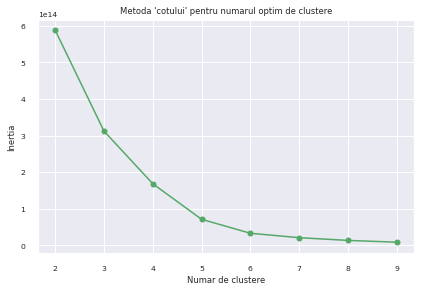

In [40]:
# utilizare "elbow method" pentru aflarea numarului optim de clustere
X = np.array(list(zip(x,y)))
inertias = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
plt.plot(range(2,10), inertias, "o-g")
plt.xlabel("Numar de clustere")
plt.ylabel("Inertia")
plt.title("Metoda 'cotului' pentru numarul optim de clustere")
plt.show()

In [41]:
# aplicarea algoritmului KMeans cu numarul optim de clustere si aflarea etichetelor fiecarei companii/inregistrari
kmeans = KMeans(n_clusters=6)
y_kmeans = kmeans.fit_predict(X)

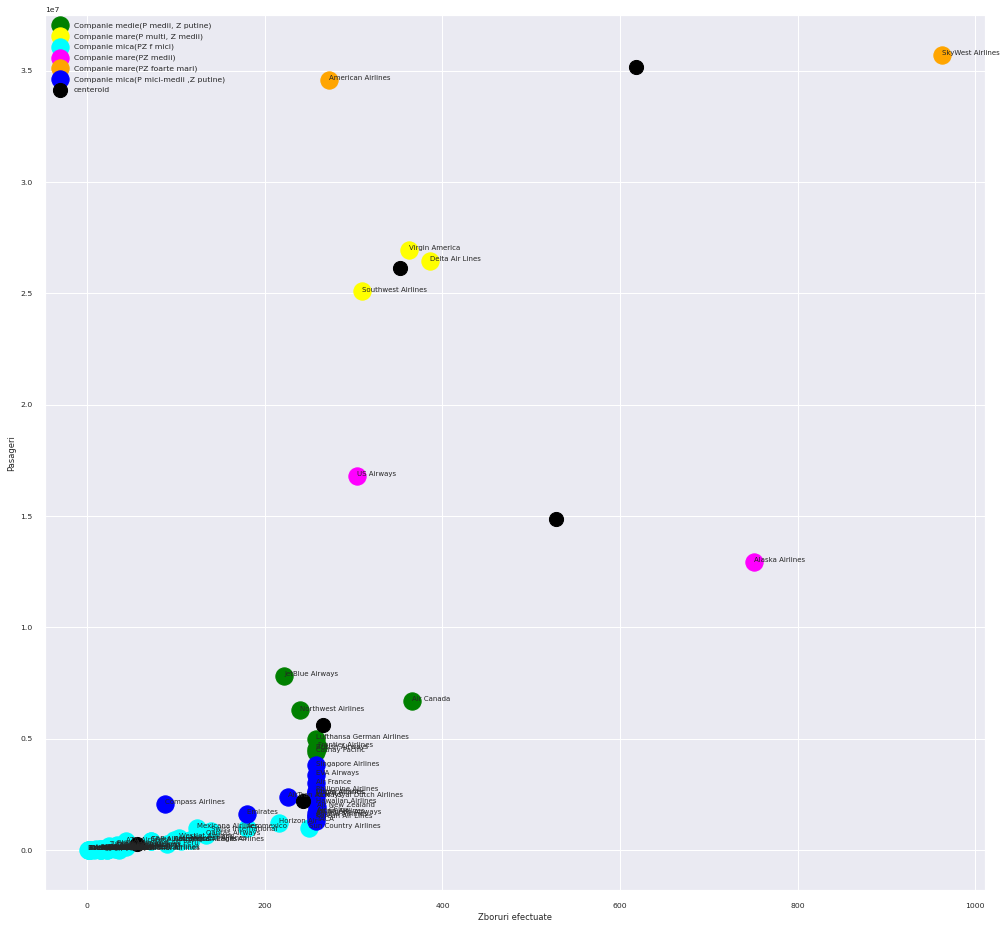

In [45]:
# plotare a clusterelor si centroizilor in functie de companie/numar de pasageri
plt.figure(figsize = (15,15))
plt.xlabel("Zboruri efectuate")
plt.ylabel("Pasageri")


# plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=300, cmap='Set1') #, cmap='Set1'
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 300, c = 'green', label = 'Companie medie(P medii, Z putine)')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 300, c = 'yellow', label = 'Companie mare(P multi, Z medii)')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 300, c = 'cyan', label = 'Companie mica(PZ f mici)')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 300, c = 'magenta', label = 'Companie mare(PZ medii)')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 300, c = 'orange', label = 'Companie mare(PZ foarte mari)')
plt.scatter(X[y_kmeans == 5, 0], X[y_kmeans == 5, 1], s = 300, c = 'blue', label = 'Companie mica(P mici-medii ,Z putine)')

for i, txt in enumerate(airline_count.index.values):
    plt.annotate(txt, (X[i,0], X[i,1]), size = 7)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], s = 200, c = 'black' , label = 'centeroid')
plt.legend()
plt.show()

In [46]:
# afisare componente pentru fiecare cluster
from collections import Counter
y_kmeans2 = list(set(y_kmeans))
print(y_kmeans2)
# print(f"Componente cluster 0:\n\tX[0](k$):{X[y_kmeans == 0, 0]}\n\tX[1]:{X[y_kmeans == 0, 1]}")
for i in y_kmeans2:
    print(f"Componente cluster {i}:\n\tX[0]-airline_counts:{X[y_kmeans == i, 0]}\n\tX[1]-passenger_count:{X[y_kmeans == i, 1]}")
# plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], s = 200, c = 'black' , label = 'centeroid')


[0, 1, 2, 3, 4, 5]
Componente cluster 0:
	X[0]-airline_counts:[366 258 258 260 222 258 240]
	X[1]-passenger_count:[6680071 4547282 4417302 4624796 7827973 4979907 6266220]
Componente cluster 1:
	X[0]-airline_counts:[386 309 362]
	X[1]-passenger_count:[26440420 25087141 26934738]
Componente cluster 2:
	X[0]-airline_counts:[ 44  98 180  36  14   8  16 106  22  22   2  22   1  14  72  32  34   2
  32 216  20  10  16  90 117  44 124  16 116   2 134  24  72  36  24 250
 139  15  24 103   3  31   2]
	X[1]-passenger_count:[ 384764  431904  983488   83547    4119   22676   24269  424692     110
   47892      68    9138      18   47853  395885  138286  220187       4
  180219 1204758   55994   63913   68485  250741  434138  126048  991232
    1718  450428     320  668823   58860  422341    3242   70105  998163
  842568    3879  195898  549830     785   68918     146]
Componente cluster 3:
	X[0]-airline_counts:[751 304]
	X[1]-passenger_count:[12955980 16816616]
Componente cluster 4:
	X[0]-airlin

In [47]:
print("---" * 5 + "Dendrograma pentru clusterele obtinute " + "---" * 5)
fig = ff.create_dendrogram(X, labels = y_kmeans)
fig.update_layout(width=800, height=500)
fig.show()

---------------Dendrograma pentru clusterele obtinute ---------------


Top 10 companii comune: [('United Airlines', 3046), ('SkyWest Airlines', 963), ('Alaska Airlines', 751), ('Delta Air Lines', 386), ('Air Canada ', 366), ('Virgin America', 362), ('Southwest Airlines', 309), ('US Airways', 304), ('American Airlines', 272), ('Frontier Airlines', 260)]
Ultimele 10 companii comune: [('Air Canada Jazz', 14), ('COPA Airlines, Inc.', 14), ('Independence Air', 10), ('Air India Limited', 8), ('World Airways', 3), ('Xtra Airways', 2), ('Evergreen International Airlines', 2), ('Pacific Aviation', 2), ('Atlas Air, Inc', 2), ('Boeing Company', 1)]


Text(0.5, 1.0, 'Piechart pentru tipurile de zbor')

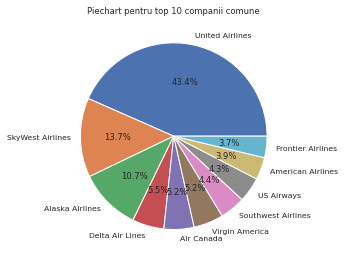

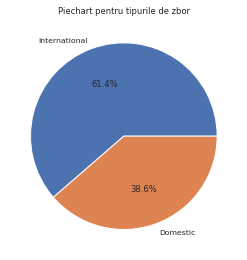

In [48]:
# afisare piechart-uri cu procentele aferente fiecarei companii(din top 10) si fiecarui tip de zbor
df.loc[df['Operating Airline'] == 'United Airlines - Pre 07/01/2013', 'Operating Airline'] = 'United Airlines'

operating_airlines = collections.Counter(df['Operating Airline'])
geo_summary = collections.Counter(df['GEO Summary'])
# print(operating_airlines.most_common(5))
# print(geo_summary.most_common())

print(f"Top 10 companii comune: {operating_airlines.most_common(10)}")
print(f"Ultimele 10 companii comune: {operating_airlines.most_common()[-10:]}")

oa = operating_airlines.most_common(10)
oa_least_common = operating_airlines.most_common()[-10:]
gs = geo_summary.most_common()


operating_airlines_cnt = [elem[1] for elem in oa]
operating_airlines_names = [elem[0] for elem in oa]
geo_summary_cnt = [elem[1] for elem in gs]
geo_summary_names = [elem[0] for elem in gs]

operating_airlines_least_common_cnt = [elem[1] for elem in oa_least_common]
operating_airlines_least_common_names = [elem[0] for elem in oa_least_common]


fig, (ax1) = plt.subplots(1,1)
ax1.pie(operating_airlines_cnt, labels=operating_airlines_names, autopct='%1.1f%%')
ax1.axes.get_xaxis().set_ticks([])
ax1.axes.get_yaxis().set_ticks([])
ax1.set_title("Piechart pentru top 10 companii comune")

fig, (ax2) = plt.subplots(1, 1)
ax2.pie(geo_summary_cnt, labels=geo_summary_names, autopct='%1.1f%%')
ax2.axes.get_xaxis().set_ticks([])
ax2.axes.get_yaxis().set_ticks([])
ax2.set_title("Piechart pentru tipurile de zbor")